<a href="https://colab.research.google.com/github/keee1/kaggle/blob/main/Titanic/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考にしたサイト：
https://qiita.com/5sigma_AAA/items/0c23907da9330681147b

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

df = pd.read_csv('/content/drive/MyDrive/Kaggle/Titanic/train.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [14]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [15]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

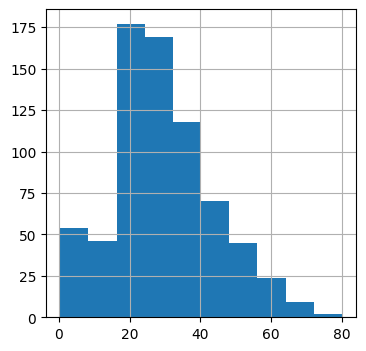

In [16]:
df["Age"].hist(figsize = (4,4))

In [ ]:
df_org = df

from sklearn.impute import SimpleImputer

df["Age"] = SimpleImputer().fit_transform(df.iloc[:,[df.columns.get_loc("Age")]])
df.isnull().sum()
df["Age"].hist(figsize = (4,4))

In [ ]:
df["Embarked"].hist(figsize = (4,4))

In [20]:
df['Embarked'] = df['Embarked'].fillna('S')

In [10]:
df["Fare"] = SimpleImputer().fit_transform(df.iloc[:,[df.columns.get_loc("Fare")]])
df.isnull().sum()
#df["Fare"].hist(figsize = (4,4))

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [ ]:
df["Cabin"].tolist()

In [22]:
df = df.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1)

In [23]:
print(df.isnull().sum())
print(df.dtypes)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object


In [24]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [25]:
df['Embarked'] = df['Embarked'].map( {'S': 0 , 'C':1 , 'Q':2}).astype(int)

In [26]:
print(df.isnull().sum())
print(df.dtypes)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Survived      int64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
dtype: object


<Axes: >

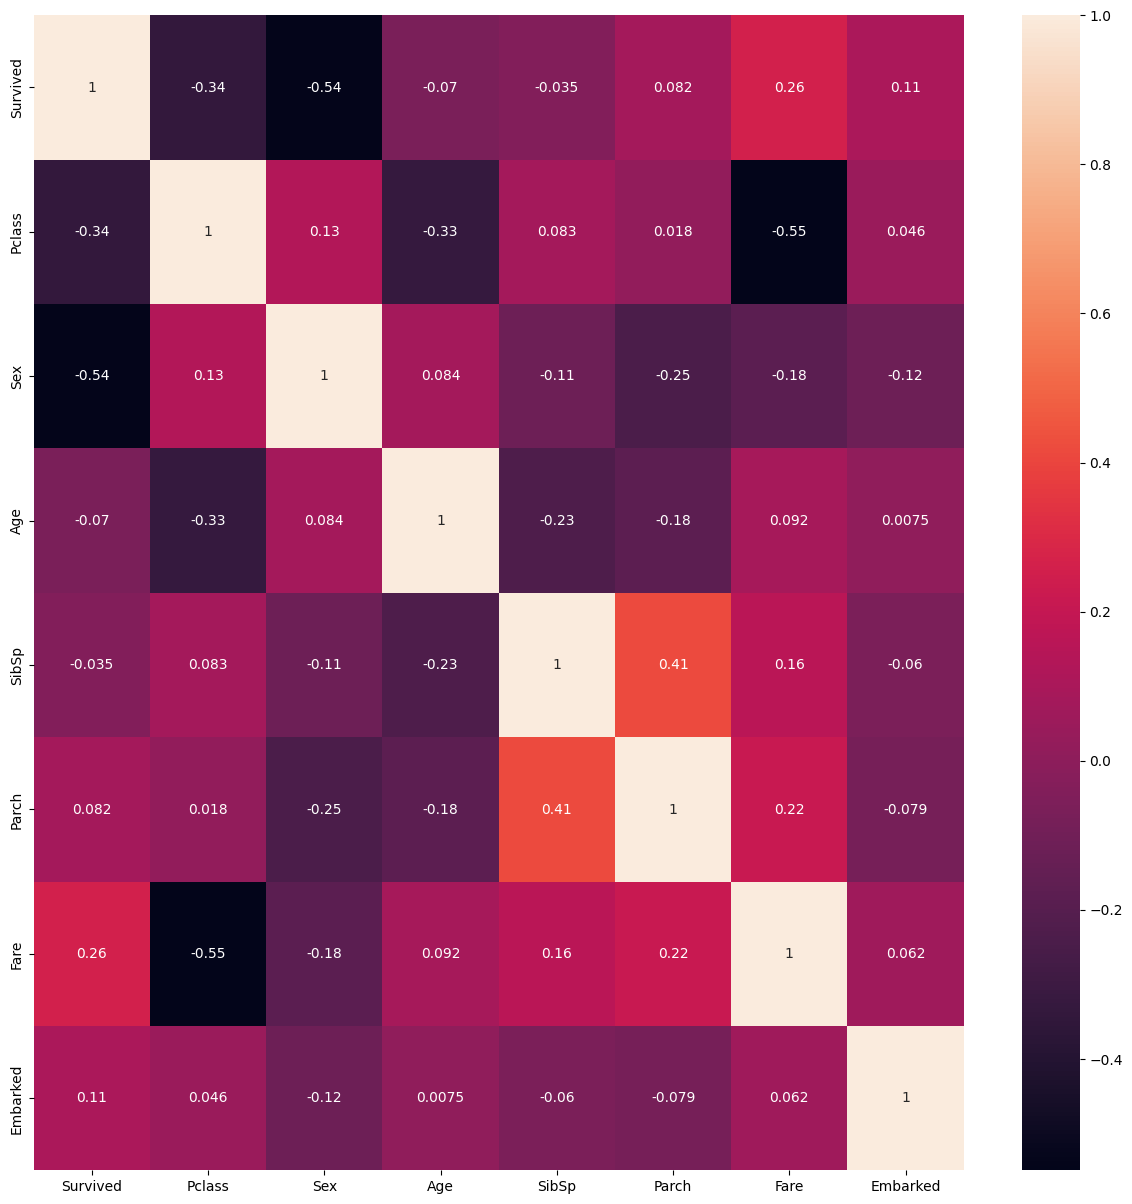

In [31]:
plt.figure(figsize = (15,15))
sns.heatmap(df.corr(),annot = True)

In [29]:
from sklearn.model_selection import  train_test_split

X = df.drop('Survived', axis=1)
Y = df.Survived

In [30]:
(train_X , test_X , train_Y , test_Y) = train_test_split(X, Y , test_size = 0.3 , random_state = 0)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve , auc ,accuracy_score, precision_score)

clf = RandomForestClassifier(n_estimators = 12,max_depth=10,random_state = 0)
clf = clf.fit(train_X , train_Y)
pred = clf.predict(test_X)
fpr, tpr , thresholds = roc_curve(test_Y,pred,pos_label = 1)
auc(fpr,tpr)
print(accuracy_score(pred,test_Y))
print(precision_score(pred, test_Y))

0.8432835820895522
0.7


In [66]:
testDf = pd.read_csv('/content/drive/MyDrive/Kaggle/Titanic/test.csv')
testDf.head()
print(testDf.isnull().sum())
testDf_org = testDf

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [67]:
from sklearn.impute import SimpleImputer

passsengerid = testDf['PassengerId']

testDf["Age"] = SimpleImputer().fit_transform(testDf.iloc[:,[testDf.columns.get_loc("Age")]])
testDf["Fare"] = SimpleImputer().fit_transform(testDf.iloc[:,[testDf.columns.get_loc("Fare")]])
testDf['Embarked'] = testDf['Embarked'].fillna('S')

testDf['Sex'] = testDf['Sex'].apply(lambda x: 1 if x == 'male' else 0)
testDf['Embarked'] = testDf['Embarked'].map( {'S': 0 , 'C':1 , 'Q':2}).astype(int)

testDf= testDf.drop(['Cabin','Name','Ticket','PassengerId'],axis =1)
pred = clf.predict(testDf)

submission = pd.DataFrame({'PassengerId':passsengerid, 'Survived':pred})
submission.to_csv('/content/drive/MyDrive/Kaggle/Titanic/submission.csv' , index = False)